In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Load the dataset
df = pd.read_csv('https://s3.amazonaws.com/static.akk.io/Akkio-NCAAHistoricalData.csv')

# Keep only the desired columns
cols_to_keep = ['Team1', 'Seed1', 'Score1', 'G1', 'FG%1', 'FT%1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PF1', 'PTS1', '2P%1', '3P%1', 'ORB1', 'DRB1',
   'Team2', 'Seed2', 'Score2', 'G2', 'FG%2', 'FT%2', 'TRB2', 'AST2', 'STL2', 'BLK2', 'TOV2', 'PF2', 'PTS2', '2P%2', '3P%2', 'ORB2', 'DRB2',
   'winner']
df = df[cols_to_keep]
df.head()

,Team1,Seed1,Score1,G1,FG%1,FT%1,TRB1,AST1,STL1,BLK1,...,STL2,BLK2,TOV2,PF2,PTS2,2P%2,3P%2,ORB2,DRB2,winner
0,Temple,1,87,34.0,0.458,0.739,38.7,14.7,6.4,5.4,...,6.5,2.2,11.8,18.7,82.0,0.506,0.411,NaN,NaN,Team1
1,Lehigh,16,73,31.0,0.490,0.724,37.1,15.3,6.5,2.2,...,6.4,5.4,9.0,15.4,76.8,0.474,0.409,NaN,NaN,Team2
2,Georgetown,8,66,30.0,0.452,0.602,39.2,14.4,10.6,3.8,...,7.3,1.8,14.7,19.6,70.4,0.483,0.335,NaN,NaN,Team1
3,LSU,9,63,30.0,0.461,0.703,36.0,15.6,7.3,1.8,...,10.6,3.8,14.3,21.3,71.9,0.476,0.351,NaN,NaN,Team2
4,Georgia Tech,5,90,32.0,0.503,0.721,35.3,21.3,7.4,2.9,...,9.2,3.8,15.3,20.7,90.2,0.515,0.357,NaN,NaN,Team1


In [ ]:
# one hot encode the winner of each game
enc = OneHotEncoder()
winner_enc = enc.fit_transform(df[['winner']])
winner_df = pd.DataFrame(winner_enc.toarray(), columns=['winner_' + str(int(i)) for i in range(winner_enc.shape[1])])
df = pd.concat([df, winner_df], axis=1)

# add the column 'seed difference' which is just Seed1 - Seed2
df['Seed Difference'] = df['Seed1'] - df['Seed2']

Initial logistic regression on 'Seed Difference', as this is the most common way to chose one team over another. A lower seed means the better a team is, so chosing this team usually gives you better odds of getting that prediction right.

In [ ]:
# create the X and y variables that will be used for training and testing
# we start with predicting the winners of games from just the Seed Difference
X = df['Seed Difference'].values.reshape(-1,1)
y = df['winner_0'].values

In [ ]:
# split the data up into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=451)

lr = LogisticRegression()

parameters = {
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none','l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.1, 1, 10, 100],
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter':[100, 250, 500]}

grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters)

grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.predict(X_test)

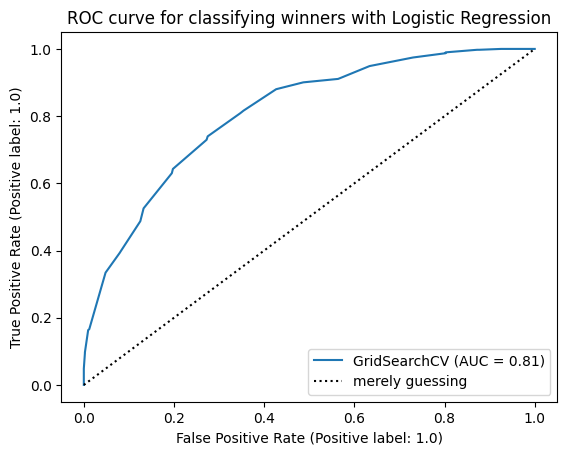

Accuracy:  0.7286245353159851
Best parameters: {'C': 0.01, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# plot an ROC curve and compare it to merely guessing
# also print out the score and the best parameters
RocCurveDisplay.from_estimator(grid_search, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying winners with Logistic Regression')
plt.legend()
plt.show(block=False)

print("Accuracy: ", accuracy_score(y_test, y_pred_grid))
print(f'Best parameters: {grid_search.best_params_}')

In [ ]:
# assign the best parameters
tuned_lr = LogisticRegression(C=0.01, max_iter = 100)
tuned_lr.fit(X_train, y_train)

LogisticRegression(C=0.01)

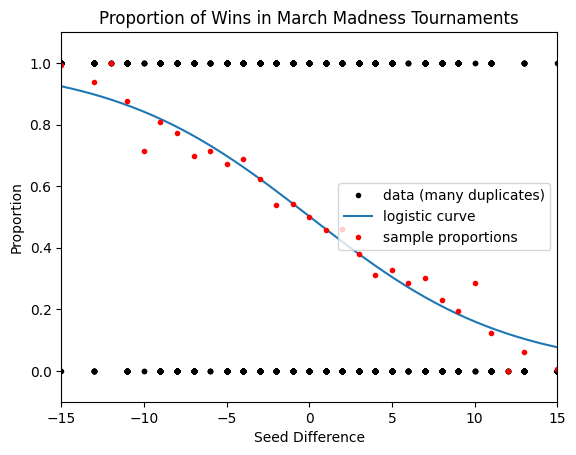

In [ ]:
# creating a logistic regression graph for the data
b = tuned_lr.intercept_
w = tuned_lr.coef_[0]

plt.plot(X, y, '.', color='black', label='data (many duplicates)')
plt.xlim(min(X), max(X))
plt.ylim(-0.1, 1.1)

plt.title('Proportion of Wins in March Madness Tournaments')
plt.xlabel('Seed Difference')
plt.ylabel('Proportion')

xplot = np.linspace(start=min(X), stop=max(X))
yplot = 1 / (1 + np.exp(-(w * xplot + b)))
plt.plot(xplot, yplot, label='logistic curve')

x_values, x_counts = np.unique(X, return_counts=True)
n_x_values = x_values.shape[0]
success_proportion_per_x_value = np.zeros(n_x_values)
for i in np.arange(n_x_values):
    success_proportion_per_x_value[i] = np.sum(y[df['Seed Difference'] == x_values[i]]) / x_counts[i]
    
probs = tuned_lr.predict_proba(X)[:, 0] # column 0 is P(y_i = 1); column 1 is P(y_i = 0)
plt.plot(x_values, success_proportion_per_x_value, '.', color='red',
         label='sample proportions')

plt.legend(loc='best')
plt.show(block=False)

Now we will compare 'Seed Difference' to other possible columns that could predict winners.

In [ ]:
# the data frame includes some na values for the team statistics, especially dating back to 1985
# doing logistic regression on values that do not exist is impossible, so we create a new one
df_no_na = df.dropna()

NOTE: The below box of code takes a lengthy time to run. This is due to the for loop in which the logistic regression and parameters loop through almost every column in the original dataframe, taking lots of time.

In [ ]:
# creating a list for all the columns that will be trained on 
train_list = ['G1', 'FG%1', 'FT%1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PF1', 'PTS1', 
             '2P%1', '3P%1', 'ORB1', 'DRB1', 'G2', 'FG%2', 'FT%2', 'TRB2', 'AST2', 'STL2', 
             'BLK2', 'TOV2', 'PF2', 'PTS2', '2P%2', '3P%2', 'ORB2', 'DRB2']


lr = LogisticRegression()

parameters = {
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none','l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.1, 1, 10, 100],
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter':[100, 250, 500]}


# looping through every column of the data frame for Team1 and Team2 other than seed difference to see the accuracy scores
# we do this as we want to see if any variable alone can out score 'Seed Difference'
for column in train_list:
    X = df_no_na[column].values.reshape(-1,1)
    y = df_no_na['winner_0']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=451)

    grid_search = GridSearchCV(estimator = lr,  param_grid = parameters)

    grid_search.fit(X_train, y_train)

    y_pred_grid = grid_search.predict(X_test)
    
    score = accuracy_score(y_test, y_pred_grid)
    print(f'{column}: {score}')

G1: 0.6799276672694394
FG%1: 0.5244122965641953
FT%1: 0.5207956600361664
TRB1: 0.5370705244122965
AST1: 0.515370705244123
STL1: 0.48282097649186256
BLK1: 0.546112115732369
TOV1: 0.5768535262206148
PF1: 0.5045207956600362
PTS1: 0.5714285714285714
2P%1: 0.5189873417721519
3P%1: 0.5063291139240507
ORB1: 0.5045207956600362
DRB1: 0.5443037974683544
G2: 0.6238698010849909
FG%2: 0.5623869801084991
FT%2: 0.5316455696202531
TRB2: 0.5533453887884268
AST2: 0.5569620253164557
STL2: 0.5280289330922242
BLK2: 0.5443037974683544
TOV2: 0.5280289330922242
PF2: 0.5352622061482821
PTS2: 0.5786618444846293
2P%2: 0.5623869801084991
3P%2: 0.5623869801084991
ORB2: 0.5406871609403255
DRB2: 0.5316455696202531


We see that the column of 'G1' has the next highest score. 'G1' is the total numbers of games played by that team for the season. We will do logistic regression on it to compare to 'Seed Difference.'

In [ ]:
# the column 'G1' has the highest score, but it is still is not as high as 'Seed Difference'
# here we do linear regression on G1 to see how it compares to seed difference
X = df_no_na['G1'].values.reshape(-1,1)
y = df_no_na['winner_0'].values.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=451)

lr = LogisticRegression()

parameters = {
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none','l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.1, 1, 10, 100],
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter':[100, 250, 500]}

grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters)

grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.predict(X_test)

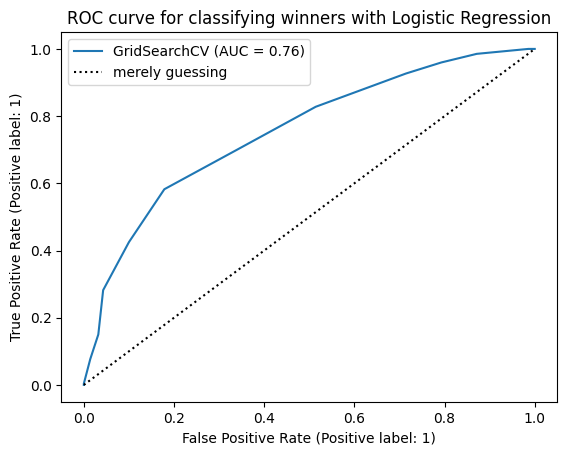

Accuracy:  0.6799276672694394
Best parameters: {'C': 0.01, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'newton-cg'}


In [ ]:
RocCurveDisplay.from_estimator(grid_search, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying winners with Logistic Regression')
plt.legend()
plt.show(block=False)

print("Accuracy: ", accuracy_score(y_test, y_pred_grid))
print(f'Best parameters: {grid_search.best_params_}')

In [ ]:
tuned_lr = LogisticRegression(C=0.01, max_iter = 100)
tuned_lr.fit(X_train, y_train)

LogisticRegression(C=0.01)

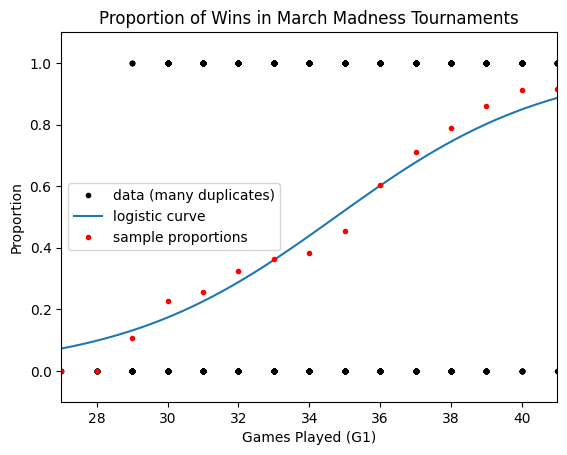

In [ ]:
b = tuned_lr.intercept_
w = tuned_lr.coef_[0]

plt.plot(X, y, '.', color='black', label='data (many duplicates)')
plt.xlim(min(X), max(X))
plt.ylim(-0.1, 1.1)

plt.title('Proportion of Wins in March Madness Tournaments')
plt.xlabel('Games Played (G1)')
plt.ylabel('Proportion')

xplot = np.linspace(start=min(X), stop=max(X))
yplot = 1 / (1 + np.exp(-(w * xplot + b)))
plt.plot(xplot, yplot, label='logistic curve')

x_values, x_counts = np.unique(X, return_counts=True)
n_x_values = x_values.shape[0]
success_proportion_per_x_value = np.zeros(n_x_values)
for i in np.arange(n_x_values):
    success_proportion_per_x_value[i] = np.sum(y[df_no_na['G1'] == x_values[i]]) / x_counts[i]
    
probs = tuned_lr.predict_proba(X)[:, 0] # column 0 is P(y_i = 1); column 1 is P(y_i = 0)
plt.plot(x_values, success_proportion_per_x_value, '.', color='red',
         label='sample proportions')

plt.legend(loc='best')
plt.show(block=False)

We see that the accuracy score of 'G1' is not as high as 'Seed Difference', meaning 'Seed Difference' is the best predictor for games (when only choosing one column).

What happens if we put 'Seed Difference' and 'G1' together though?

In [ ]:
X = df_no_na[['Seed Difference', 'G1']]
y = df_no_na['winner_0'].values.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=451)

lr = LogisticRegression()

parameters = {
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none','l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.1, 1, 10, 100],
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter':[100, 250, 500]}

grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters)

grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.predict(X_test)

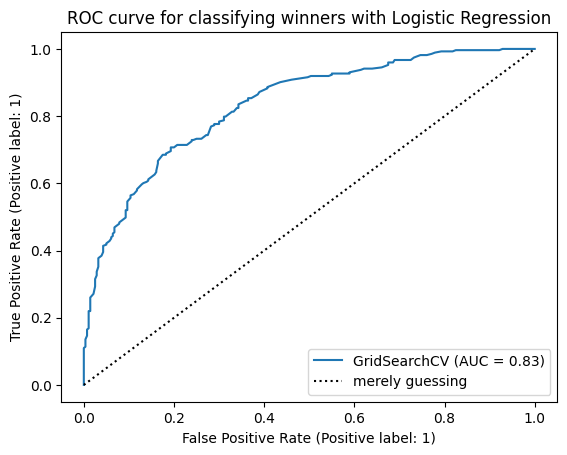

Accuracy:  0.7359855334538878
Best parameters: {'C': 0.01, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
RocCurveDisplay.from_estimator(grid_search, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying winners with Logistic Regression')
plt.legend()
plt.show(block=False)

print("Accuracy: ", accuracy_score(y_test, y_pred_grid))
print(f'Best parameters: {grid_search.best_params_}')

This is the highest score yet, but it's really not that much improvement from just 'Seed Difference', which makes it seem that the seeding created for the tournmanets is quite accurate.

Now we will run logistic regression on every single variable in the data set together. This, in theory, should have the highest accuracy. (this code will also take a lengthy amount of time to run due to the high number of columns in X)

In [ ]:
X = df_no_na[['Seed Difference', 'G1', 'FG%1', 'FT%1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PF1', 'PTS1', 
             '2P%1', '3P%1', 'ORB1', 'DRB1', 'G2', 'FG%2', 'FT%2', 'TRB2', 'AST2', 'STL2', 
             'BLK2', 'TOV2', 'PF2', 'PTS2', '2P%2', '3P%2', 'ORB2', 'DRB2']]
y = df_no_na['winner_0'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=451)

lr = LogisticRegression()

parameters = {
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none','l1', 'l2', 'elasticnet'],
              'C':[0.01, 0.1, 1, 10, 100],
              'multi_class':['auto', 'ovr', 'multinomial'],
              'max_iter':[100, 250, 500]}

grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters)

grid_search.fit(X_train, y_train)

y_pred_grid = grid_search.predict(X_test)

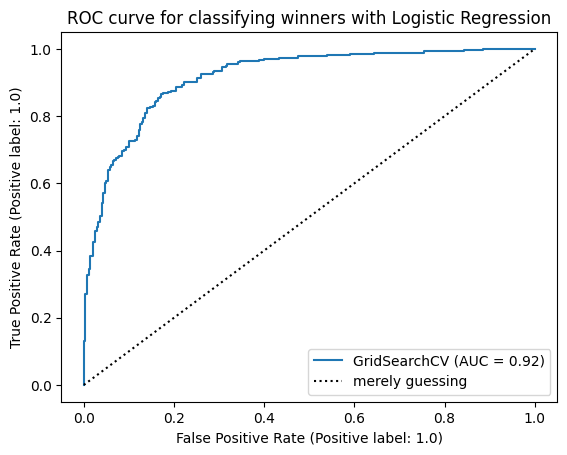

Accuracy:  0.8426763110307414
Best parameters: {'C': 0.01, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
RocCurveDisplay.from_estimator(grid_search, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying winners with Logistic Regression')
plt.legend()
plt.show(block=False)

print("Accuracy: ", accuracy_score(y_test, y_pred_grid))
print(f'Best parameters: {grid_search.best_params_}')

This is the highest accuracy yet, which we expected.

Finally, we will see how using this method of choosing the better seed would've worked on the 2023 tournament.

Creating predictions and testing accuracy for the entire bracket is very difficult due to the fact that there are many rounds, and each round is dependent on the previous round. This means that after a few rounds, none of the teams we might predict may still even be in the bracket, which makes accuracy testing very difficult. Here we will only test accuracy on the Round of 64 for the 2023 tournament to see how well we could do on the initial round.

In [ ]:
# creating the columns
real_64 =  pd.DataFrame(columns = ['Winner Seed', 'Winner', 'Loser Seed', 'Loser'])

# manually creating a list of each winning team and their seed for round of 64
winner = ['Alabama', 'Maryland', 'San Diego St.', 'Furman', 'Creighton', 'Baylor', 'Missouri', 'Princeton',
         'Fairleigh Dickinson', 'Florida Atlantic', 'Duke', 'Tennessee', 'Kentucky', 'Kansas St.', 
          'Michigan State', 'Marquette', 'Houston', 'Auburn', 'Miami (FL)', "Indiana", 'Pittsburgh', 'Xavier',
         'Penn St.', 'Texas', 'Kansas', 'Arkansas', "Saint Mary's", 'UConn', 'TCU', 'Gonzaga', 'Northwestern',
         'UCLA']
winner_seed = [1,8,5,13,6,3,7,15,
               16,9,5,4,6,3,7,2,
              1,9,5,4,11,3,10,2,
               1,8,5,4,6,3,7,2]

# manually creating a list of each correspoding losing team (against the winning team above) 
# and their seed for round of 64
loser = ['Texas A&M-CC', 'West Virginia', 'Charleston,', 'Virginia', 'NC State', 'UCSB', 'Utah St.', 'Arizona', 
         'Purdue', 'Memphis', 'Oral Roberts', 'Louisiana', 'Providence', 'Montana St.', 'USC', 'Vermont',
        'Northern Kentucky', 'Iowa', 'Drake', 'Kent St.', 'Iowa St.', 'Kennesaw St.', 'Texas A&M', 'Colgate',
        'Howard', 'Illinois', 'VCU', 'Iona', 'Arizona St.', 'Grand Canyon', 'Boise St.', 'UNC Asheville']
loser_seed = [16,9,12,4,11,14,10,2,
              1,8,12,13,11,14,10,15,
             16,8,12,13,6,14,7,15,
             16,9,12,13,11,14,10,15]

# adding values to the columns
real_64['Winner Seed'] = winner_seed
real_64['Winner'] = winner
real_64['Loser Seed'] = loser_seed
real_64['Loser'] = loser
real_64['Seed Difference'] = real_64['Winner Seed'] - real_64['Loser Seed']

# adding a column for the real winner of each game (always 1.0 for the first team winning)
real_64['real winner'] = 1.0

# adding a column for the predicted winner of each game (will be 0.0 if the lower seed lost)
real_64['predicted winner'] = None
for i, row in real_64.iterrows():
    # to see which teams seed is lower
    if row['Loser Seed'] < row['Winner Seed']:
        # 0.0 if the lower team should have won but lost
        real_64.at[i, 'predicted winner'] = 0.0
    else:
        # 1.0 is the lower seed won
        real_64.at[i, 'predicted winner'] = 1.0
real_64['predicted winner'] = real_64['predicted winner'].astype(int)
real_64['real winner'] = real_64['real winner'].astype(int)

In [ ]:
y_pred = real_64['predicted winner']
y_true = real_64['real winner']

accuracy_score = accuracy_score(y_true, y_pred)
print(f'From simply picking the lower seed in the 2023 tournament for the round of 64, your bracket would have started off with an accuracy score of {accuracy_score}')

From simply picking the lower seed in the 2023 tournament for the round of 64, your bracket would have started off with an accuracy score of 0.78125


Simply from chosing the lower seed, our bracket would've been about 78% correct through the first round. This equates to choosing about 25 out of the 32 games correctly, which is not terrible. It helps to show that the seeding that is created is effective, but also proves how upsets are common and not always predictable too.